In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import pickle
from copy import deepcopy
from astropy.io import fits
from scipy.stats import norm as scipy_norm
from scipy.optimize import minimize
from scipy.ndimage.filters import gaussian_filter
import matplotlib.gridspec as gridspec

from lsst.eotest.sensor import parse_geom_kwd, makeAmplifierGeometry
from lsst.eotest.sensor.spotTask import make_ccd_mosaic
from lsst.eotest.sensor.MaskedCCD import MaskedCCD

from mixcoatl.crosstalk import make_stamp, crosstalk_model_fit, calibrated_stack, crosstalk_model

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    a = int(float(a))
    b = int(b)
    if a > 0.0:
        return r'${0:d}\times 10^{{{1}}}$'.format(a, b)
    elif a < 0.0:
        return r'${0:d}\times 10^{{{1}}}$'.format(a, b)
    elif a ==0.0:
        return r'0'
    
def chi_square(params, x, y):
    
    mu = params[0]
    sigma = 10**params[1]
    
    binwidth = x[1]-x[0]
    
    pdf_y = scipy_norm.pdf(x, mu, sigma)*binwidth*np.sum(y)
    
    return np.sum((pdf_y-y)**2.)/float(np.sum(y))

# Cross Talk Image

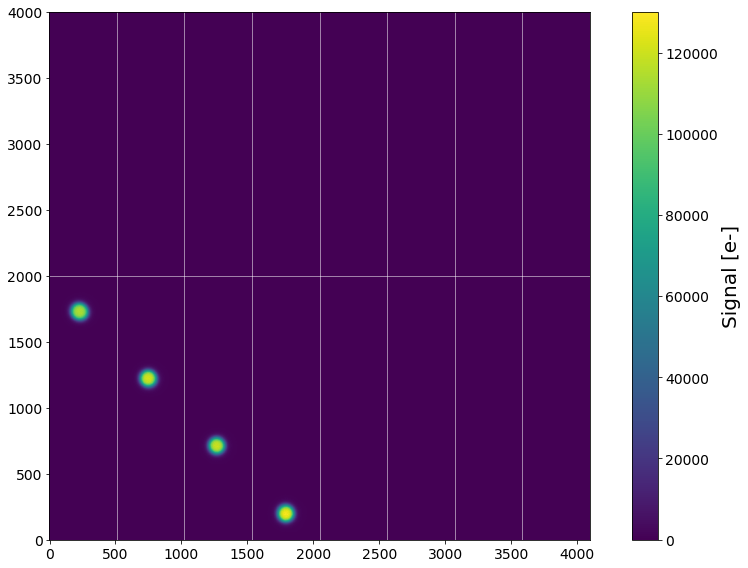

In [24]:
xtalk_image = 'MC_C_20191018_000474_R21_S11.fits'
calib_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/calibration/'

gain_results = pickle.load(open(os.path.join(calib_dir, 
                                                 'et_results.pkl'), 'rb'))
gains = gain_results.get_amp_gains('R21_S11')

dark_image = os.path.join(calib_dir, 'R21_S11_superdark.fits')
bias_image = os.path.join(calib_dir, 'R21_S11_superbias.fits')

imarr = make_ccd_mosaic(xtalk_image, bias_frame=bias_image, dark_frame=dark_image, gains=gains).getArray()

## Plot cross talk image
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
im = ax.imshow(imarr, origin='lower')

## Overlay amplifier boundaries
for i in range(1, 8):
    ax.axvline(x=i*512-1., color='white', linewidth=0.5)
ax.axhline(y=2001, color='white', linewidth=0.5)

ax.tick_params(axis='both', which='major', labelsize=14)

cbar = fig.colorbar(im)
cbar.set_label("Signal [e-]", size=20)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('crosstalk_image_example.png')

1223 251


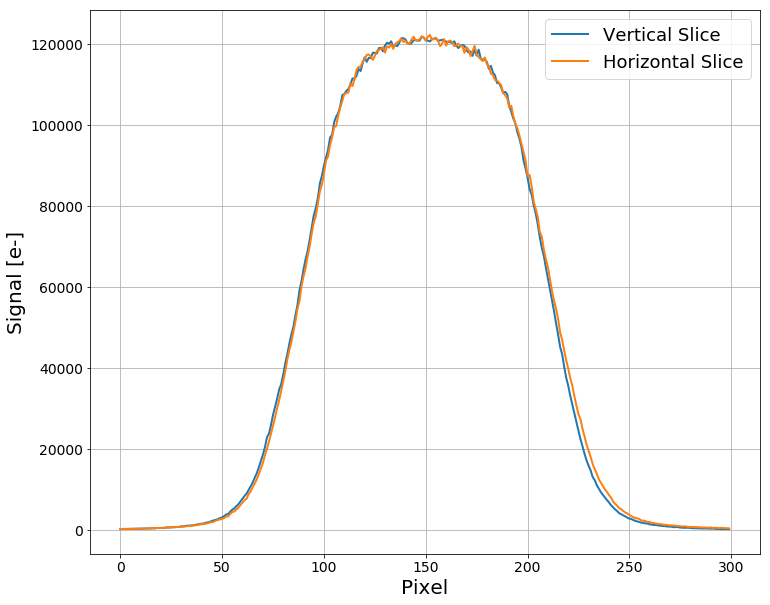

In [25]:
## Get spot subimage
subimarr = imarr[0:2000, 500:1000]
smoothed = gaussian_filter(subimarr, 20)
y, x = np.unravel_index(smoothed.argmax(), smoothed.shape)

print(y, x)
l = 300
stamp = make_stamp(subimarr, y, x, l = 300)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(stamp[:, l//2], label='Vertical Slice', linewidth=2.)
ax.plot(stamp[l//2, :], label='Horizontal Slice', linewidth=2.)
ax.grid(which='major', axis='both')
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Signal [e-]', fontsize=20)
ax.set_xlabel('Pixel', fontsize=20)
plt.savefig('crosstalk_spot_profile')

# Cross Talk Model Fit Example

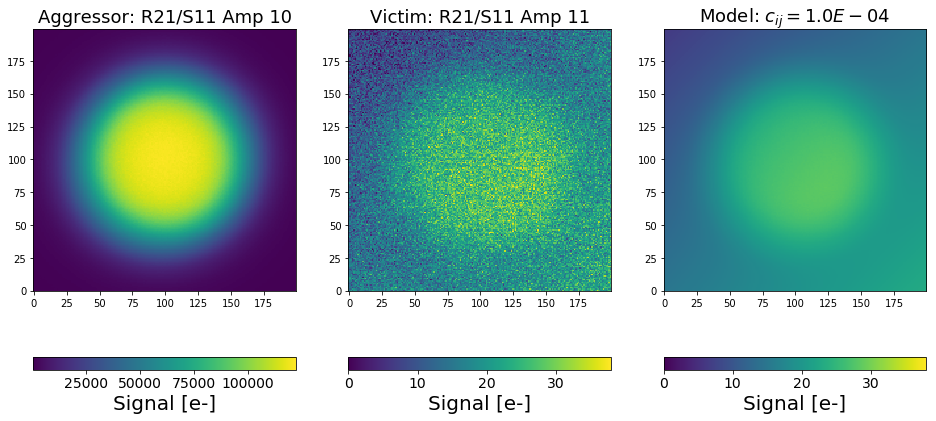

In [22]:
infiles = glob.glob('MC_C_*_R21_S11.fits')
calib_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/calibration/'
gain_results = pickle.load(open(os.path.join(calib_dir, 
                                                 'et_results.pkl'), 'rb'))
gains = gain_results.get_amp_gains('R21_S11')

dark_image = os.path.join(calib_dir, 'R21_S11_superdark.fits')
bias_image = os.path.join(calib_dir, 'R21_S11_superbias.fits')

ccds = [MaskedCCD(infile, bias_frame=bias_image, 
                   dark_frame=dark_image) for infile in infiles]

amp=10
imarr1 = calibrated_stack(ccds, amp, gain=gains[amp])
    
smoothed = gaussian_filter(imarr1, 20)
y, x = np.unravel_index(smoothed.argmax(), smoothed.shape)
stamp1 = make_stamp(imarr1, y, x)

## Calculate crosstalk for each victim amp
i = 11
imarr2 = calibrated_stack(ccds, i, gain=gains[i])
stamp2 = make_stamp(imarr2, y, x)
res = crosstalk_model_fit(stamp1, stamp2, noise=7.0,
                          num_iter=3,
                          nsig=5)
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
im0 = axes[0].imshow(stamp1, origin='lower', interpolation='none')
cbar0 = fig.colorbar(im0, ax=axes[0], orientation='horizontal')
cbar0.ax.tick_params(labelsize=14)
cbar0.set_label("Signal [e-]", size=20)
axes[0].set_title(r'Aggressor: R21/S11 Amp 10', fontsize=18)

im1 = axes[1].imshow(stamp2, origin='lower', vmin=0, vmax=38, interpolation='none')
cbar1 = fig.colorbar(im1, ax=axes[1], orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label("Signal [e-]", size=20)
axes[1].set_title(r'Victim: R21/S11 Amp 11', fontsize=18)

model = crosstalk_model(res, stamp1)
im2 = axes[2].imshow(model, origin='lower', vmin=0, vmax=38, interpolation='none')
cbar2 = fig.colorbar(im2, ax=axes[2], orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label("Signal [e-]", size=20)
axes[2].set_title(r'Model: $c_{{ij}}={0:.1E}$'.format(res[0]), fontsize=18) # modify depending on cross talk variable
plt.savefig('crosstalk_model_fit_example.png')

# Single Sensor Cross Talk Results

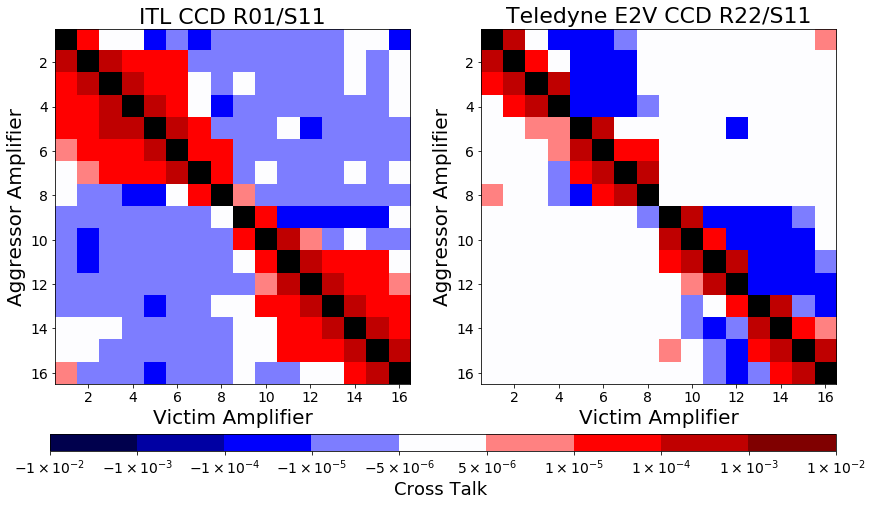

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes = axes.flatten()

## Make a binned colormap and normalize
cmap = plt.cm.seismic
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
cmap.set_bad(color='black')

bounds = np.asarray([-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-5.0E-6, 5.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2])
norm = colors.BoundaryNorm(bounds, cmap.N)

## Add ITL results
raft_id = 'R01'
sensor_id = 'S11'

results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/results/'
crosstalk_results = os.path.join(results_dir,
                                 '{0}_{1}_{0}_{1}_crosstalk_results.fits'.format(raft_id, sensor_id))
with fits.open(crosstalk_results) as hdulist:
    sensor_xtalk = hdulist[0].data   
np.fill_diagonal(sensor_xtalk, np.nan)

im0 = axes[0].imshow(sensor_xtalk, norm=norm, cmap=cmap, interpolation='none', extent=(0.5, 16.5, 16.5, 0.5))

axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_ylabel('Aggressor Amplifier', fontsize=20)
axes[0].set_xlabel('Victim Amplifier', fontsize=20)
axes[0].set_title('ITL CCD R01/S11', fontsize=22)

## Add E2V results
raft_id = 'R21'
sensor_id = 'S11'

results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/results/'
crosstalk_results = os.path.join(results_dir,
                                 '{0}_{1}_{0}_{1}_crosstalk_results.fits'.format(raft_id, sensor_id))
with fits.open(crosstalk_results) as hdulist:
    sensor_xtalk = hdulist[0].data   
np.fill_diagonal(sensor_xtalk, np.nan)

im1 = axes[1].imshow(sensor_xtalk, norm=norm, cmap=cmap, interpolation='none', extent=(0.5, 16.5, 16.5, 0.5))

axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_ylabel('Aggressor Amplifier', fontsize=20)
axes[1].set_xlabel('Victim Amplifier', fontsize=20)
axes[1].set_title('Teledyne E2V CCD R22/S11', fontsize=22)

#fig.subplots_adjust(right=0.85)
#cbar_ax = fig.add_axes([0.87, 0.2, 0.02, 0.6])
#cbar = fig.colorbar(im0, cax=cbar_ax, orientation='vertical', format=ticker.FuncFormatter(fmt))
fig.subplots_adjust(bottom=0.17)
cbar_ax = fig.add_axes([0.12, 0.1, 0.78, 0.03])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal', format=ticker.FuncFormatter(fmt))
cbar.set_label("Cross Talk ", size=18)
cbar.ax.tick_params(labelsize=14)
plt.savefig('intrasensor_crosstalk_matrix.png')

# Single Raft Cross Talk Results

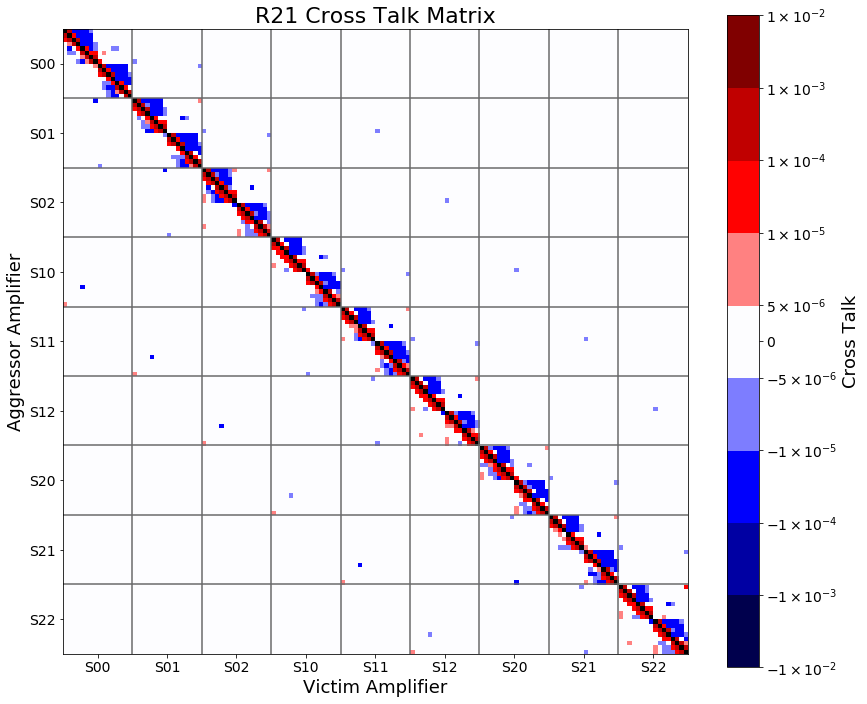

In [8]:
## Get raft results
raft_id = 'R21'

sensor_list = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']

results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/results/'
raft_xtalk = np.full((9*16, 9*16), np.nan)
for i, sensor_id in enumerate(sensor_list):
    
    for j, sensor_id2 in enumerate(sensor_list):
        
        try:
            crosstalk_results = os.path.join(results_dir,
                                             '{0}_{1}_{0}_{2}_crosstalk_results.fits'.format(raft_id, sensor_id, sensor_id2))
            with fits.open(crosstalk_results) as hdulist:
                xtalk = hdulist[0].data
        except Exception as e:
            print(e)
            xtalk = np.full((16, 16), np.nan)
                
        raft_xtalk[i*16:(i+1)*16, j*16:(j+1)*16] = xtalk

np.fill_diagonal(raft_xtalk, np.nan)

## Make a binned colormap and normalize
cmap = plt.cm.seismic
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
cmap.set_bad(color='black')

bounds = np.asarray([-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-5.0E-6, 5.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2])
norm = colors.BoundaryNorm(bounds, cmap.N)

## Plot 
fig, ax = plt.subplots(1,1, figsize=(14, 12))
im1 = ax.imshow(raft_xtalk, norm=norm, cmap=cmap, interpolation='none')

## Add lines to differentiate CCD regions
for i in range(8):
    ax.axvline(x=15.5+16*i, color='dimgray')
for i in range(8):
    ax.axhline(y=15.5+16*i, color='dimgray')

## Set up binned colorbar
cbar = fig.colorbar(im1,  ax=ax, orientation='vertical', 
                    ticks=[-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5, -5.0E-6, 0.0, 5.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2],
                    format=ticker.FuncFormatter(fmt))
cbar.set_label("Cross Talk", size=18)
cbar.ax.tick_params(labelsize=14)

## Label by CCD
labels = ('S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22')
ax.set_xticks([7.5+16*i for i in range(9)])
ax.set_yticks([7.5+16*i for i in range(9)])
ax.set_xticklabels(labels, {'fontsize':14})
ax.set_yticklabels(labels, {'fontsize':14})

ax.set_ylabel('Aggressor Amplifier', fontsize=18)
ax.set_xlabel('Victim Amplifier', fontsize=18)
ax.set_title('{0} Cross Talk Matrix'.format(raft_id), fontsize=22)
plt.savefig('{0}_{1}_raft_crosstalk_matrix.png'.format(raft_id, raft_id))

# Inter-Raft Cross Talk Histograms

/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


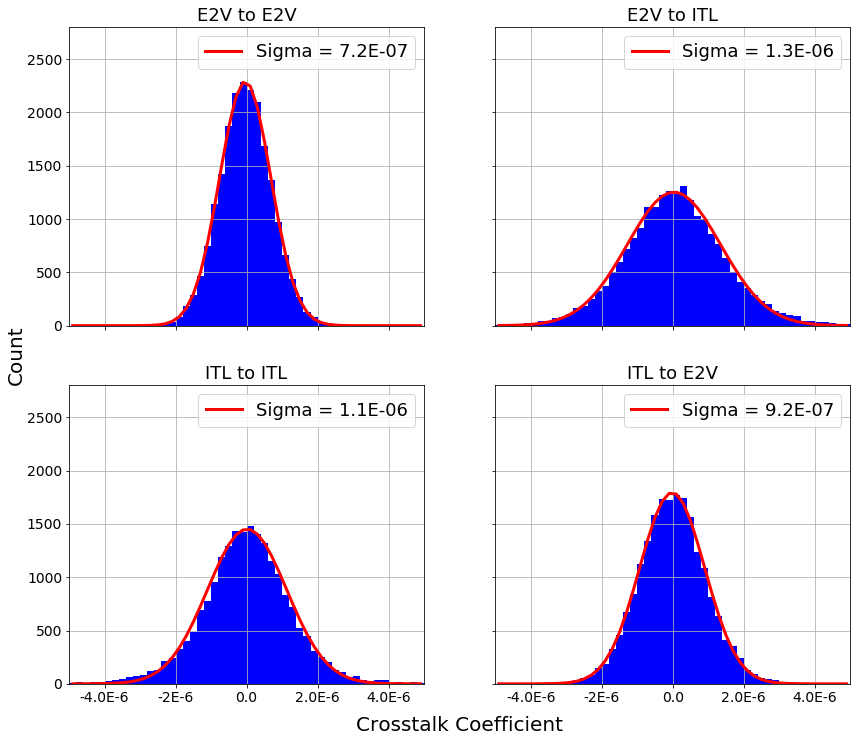

In [2]:
raft_pairs = [('R21', 'R22'),
              ('R21', 'R20'),
              ('R01', 'R02'),
              ('R01', 'R11')]

sensor_list = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']

results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/old/'

fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True, sharex=True)
axes = axes.flatten()

labels = ['E2V to E2V', 'E2V to ITL', 'ITL to ITL', 'ITL to E2V']

for k, pair in enumerate(raft_pairs):
    
    raft_id1 = pair[0]
    raft_id2 = pair[1]

    raft_xtalk = np.full((9*16, 9*16), np.nan)
    for i, sensor_id in enumerate(sensor_list):

        for j, sensor_id2 in enumerate(sensor_list):

            try:
                crosstalk_results = os.path.join(results_dir,
                                                 '{0}_{1}_{2}_{3}_crosstalk_results.fits'.format(raft_id1, sensor_id, 
                                                                                                 raft_id2, sensor_id2))
                with fits.open(crosstalk_results) as hdulist:
                    xtalk = hdulist[0].data
            except Exception as e:
                print(e)
                xtalk = np.full((16, 16), np.nan)

            raft_xtalk[i*16:(i+1)*16, j*16:(j+1)*16] = xtalk

    if raft_id1 == raft_id2:

        ## Get lower triangle
        low = np.tril(raft_xtalk, k=-17)
        high = np.triu(raft_xtalk, k=17)

        data = np.append(low[(low !=0.)*(np.abs(low)<1.E-4)].flatten(), high[(high !=0.)*(np.abs(high)<1.E-4)].flatten())

    else:
        data = raft_xtalk[np.abs(raft_xtalk)<1.E-4].flatten()

    n, binedges, patches = axes[k].hist(data, bins=50, range=(-0.5E-5, 0.5E-5), color='blue')

    ## Best fit Gaussian
    bincenters = (binedges[1:] + binedges[:-1])/2.
    binwidth = bincenters[1]-bincenters[0]
    r = minimize(chi_square, [np.nanmean(data), -6], args=(bincenters, n), method='L-BFGS-B',
                 bounds=[(-1E-6, 1E-6), (-8, -3)])
    bestFit = scipy_norm.pdf(bincenters, r.x[0], 10**r.x[1])
    axes[k].plot(bincenters, bestFit*binwidth*np.sum(n), color='red', label='Sigma = {0:.1E}'.format(10**r.x[1]), linewidth=3)

    axes[k].set_title(labels[k], fontsize=18)
    axes[k].legend(fontsize=18)
    axes[k].set_xlim(-0.5E-5, 0.5E-5)
    axes[k].set_ylim(0, 2800)
    axes[k].tick_params(axis='x', labelsize=14)
    axes[k].tick_params(axis='y', labelsize=14)
    axes[k].set_xticks([-4.0E-6, -2E-6, 0.0, 2.0E-6, 4.0E-6])
    axes[k].set_xticklabels(['-4.0E-6', '-2E-6', '0.0', '2.0E-6', '4.0E-6'], {'fontsize':14})
    axes[k].grid(which='major', axis='both')
    
fig.subplots_adjust(bottom=0.12)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, 
                left=False, right=False)
plt.ylabel('Count', fontsize=20, labelpad=20)
plt.xlabel('Crosstalk Coefficient', fontsize=20, labelpad=15)
plt.savefig('InterRaft_crosstalk_results.png')

## E2V Crosstalk vs Signal

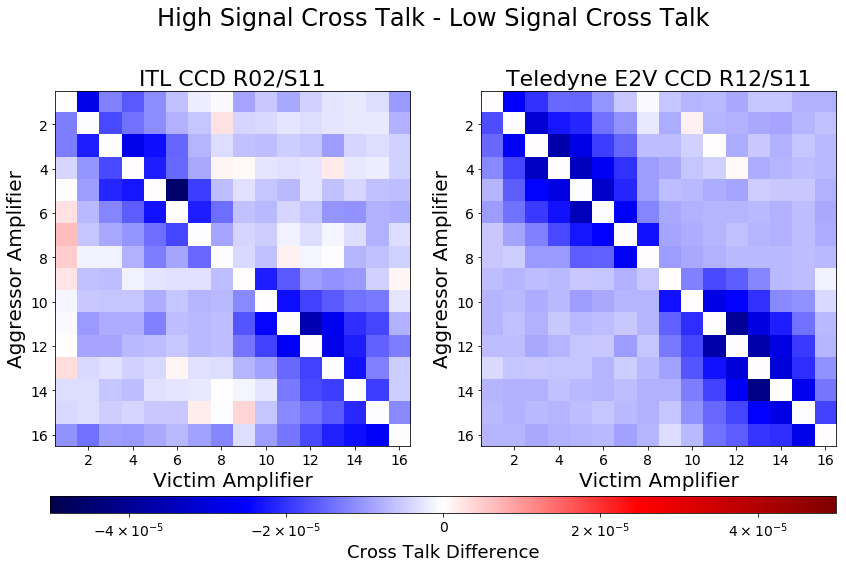

In [12]:
results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT'

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes = axes.flatten()

## Add ITL results
sensor_id = 'R02_S11_R02_S11'

low_file = os.path.join(results_dir, '6828D_xtalk_linearity', 'results', '{0}_crosstalk_results.fits'.format(sensor_id))
high_file = os.path.join(results_dir, '6833D_xtalk_linearity', 'results', '{0}_crosstalk_results.fits'.format(sensor_id))

hdul_low = fits.open(low_file)
hdul_high = fits.open(high_file)
xtalk_diff = hdul_high[0].data - hdul_low[0].data

im0 = axes[0].imshow(xtalk_diff, interpolation='none', extent=[0.5, 16.5, 16.5, 0.5], 
                     cmap='seismic', vmin = -0.00005, vmax= 0.00005)

axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_ylabel('Aggressor Amplifier', fontsize=20)
axes[0].set_xlabel('Victim Amplifier', fontsize=20)
axes[0].set_title('ITL CCD R02/S11', fontsize=22)

## Add E2V results
sensor_id = 'R12_S11_R12_S11'

low_file = os.path.join(results_dir, '6835D_xtalk_linearity', 'results', '{0}_crosstalk_results.fits'.format(sensor_id))
high_file = os.path.join(results_dir, '6834D_xtalk_linearity', 'results', '{0}_crosstalk_results.fits'.format(sensor_id))

hdul_low = fits.open(low_file)
hdul_high = fits.open(high_file)
xtalk_diff = hdul_high[0].data - hdul_low[0].data

im1 = axes[1].imshow(xtalk_diff, interpolation='none', extent=[0.5, 16.5, 16.5, 0.5], 
                     cmap='seismic', vmin = -0.00005, vmax= 0.00005)

axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_ylabel('Aggressor Amplifier', fontsize=20)
axes[1].set_xlabel('Victim Amplifier', fontsize=20)
axes[1].set_title('Teledyne E2V CCD R12/S11', fontsize=22)

fig.subplots_adjust(bottom=0.17)
cbar_ax = fig.add_axes([0.12, 0.1, 0.78, 0.03])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal', format=ticker.FuncFormatter(fmt))
cbar.set_label("Cross Talk Difference", size=18)
cbar.ax.tick_params(labelsize=14)

plt.suptitle('High Signal Cross Talk - Low Signal Cross Talk', fontsize=24)
plt.savefig('crosstalk_linearity.png')

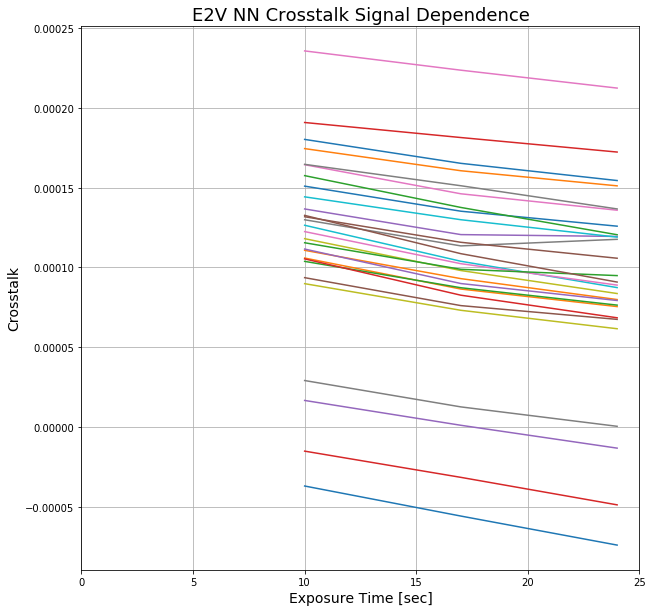

In [19]:
r = np.zeros((3, 28))
nn_up = np.diagonal(low_results[0].data, 1)
nn_up = np.delete(nn_up, (7,))
nn_down = np.diagonal(low_results[0].data, -1)
nn_down = np.delete(nn_down, (7,))
r[0, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(med_results[0].data, 1)
nn_up = np.delete(nn_up, (7,))
nn_down = np.diagonal(med_results[0].data, -1)
nn_down = np.delete(nn_down, (7,))
r[1, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(high_results[0].data, 1)
nn_up = np.delete(nn_up, (7,))
nn_down = np.diagonal(high_results[0].data, -1)
nn_down = np.delete(nn_down, (7,))
r[2, :] = np.append(nn_up, nn_down)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exptimes = np.asarray([10, 17, 24])
for i in range(r.shape[1]):
    ax.plot(exptimes, r[:, i])
    
#ax.set_ylim(0, 0.0003)
ax.set_xlim(0, 25)
ax.grid(True, which='both')
ax.set_xlabel('Exposure Time [sec]', fontsize=14)
ax.set_ylabel('Crosstalk', fontsize=14)
ax.set_title('E2V NN Crosstalk Signal Dependence', fontsize=18)
plt.savefig('E2V_NN_xtalk_signal_dependence.png')

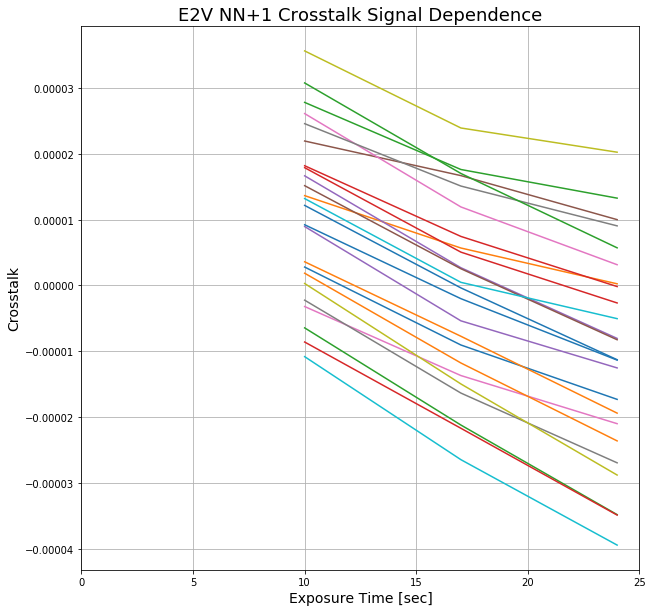

In [22]:
r = np.zeros((3, 24))
nn_up = np.diagonal(low_results[0].data, 2)
nn_up = np.delete(nn_up, (6, 7))
nn_down = np.diagonal(low_results[0].data, -2)
nn_down = np.delete(nn_down, (6, 7))
r[0, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(med_results[0].data, 2)
nn_up = np.delete(nn_up, (6, 7))
nn_down = np.diagonal(med_results[0].data, -2)
nn_down = np.delete(nn_down, (6, 7))
r[1, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(high_results[0].data, 2)
nn_up = np.delete(nn_up, (6, 7))
nn_down = np.diagonal(high_results[0].data, -2)
nn_down = np.delete(nn_down, (6, 7))
r[2, :] = np.append(nn_up, nn_down)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exptimes = np.asarray([10, 17, 24])
for i in range(r.shape[1]):
    ax.plot(exptimes, r[:, i])
    
#ax.set_ylim(0, 0.0003)
ax.set_xlim(0, 25)
ax.grid(True, which='both')
ax.set_xlabel('Exposure Time [sec]', fontsize=14)
ax.set_ylabel('Crosstalk', fontsize=14)
ax.set_title('E2V NN+1 Crosstalk Signal Dependence', fontsize=18)
plt.savefig('E2V_NNp1_xtalk_signal_dependence.png')

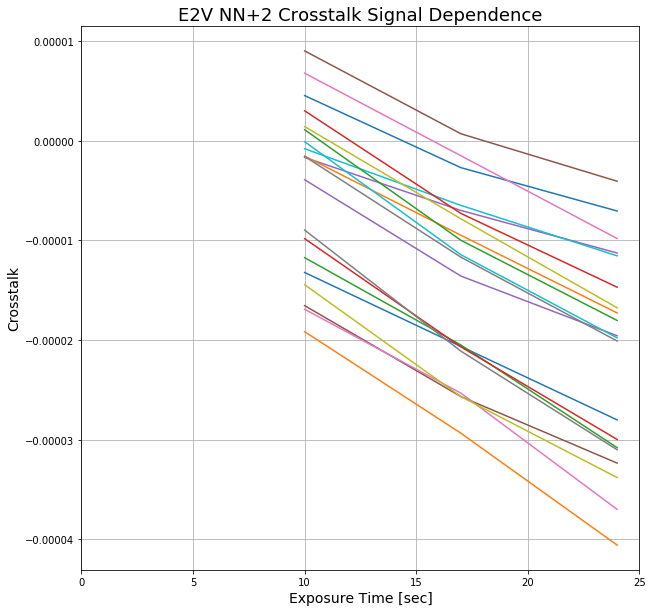

In [28]:
r = np.zeros((3, 20))
nn_up = np.diagonal(low_results[0].data, 3)
nn_up = np.delete(nn_up, (5, 6, 7))
nn_down = np.diagonal(low_results[0].data, -3)
nn_down = np.delete(nn_down, (5, 6, 7))
r[0, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(med_results[0].data, 3)
nn_up = np.delete(nn_up, (5, 6, 7))
nn_down = np.diagonal(med_results[0].data, -3)
nn_down = np.delete(nn_down, (5, 6, 7))
r[1, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(high_results[0].data, 3)
nn_up = np.delete(nn_up, (5, 6, 7))
nn_down = np.diagonal(high_results[0].data, -3)
nn_down = np.delete(nn_down, (5, 6, 7))
r[2, :] = np.append(nn_up, nn_down)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exptimes = np.asarray([10, 17, 24])
for i in range(r.shape[1]):
    ax.plot(exptimes, r[:, i])
    
#ax.set_ylim(0, 0.0003)
ax.set_xlim(0, 25)
ax.grid(which='both', axis='both')
ax.set_xlabel('Exposure Time [sec]', fontsize=14)
ax.set_ylabel('Crosstalk', fontsize=14)
ax.set_title('E2V NN+2 Crosstalk Signal Dependence', fontsize=18)
plt.savefig('E2V_NNp2_xtalk_signal_dependence.png')

## ITL Crosstalk vs Signal

In [5]:
sensor_id = 'R02_S11_R02_S11'
results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT'

low_file = join(results_dir, '6828D_xtalk_linearity', '{0}_crosstalk_results.fits'.format(sensor_id))
high_file = join(results_dir, '6833D_xtalk_linearity', 'results', '{0}_crosstalk_results.fits'.format(sensor_id))

print(low_file, high_file)

low_results = fits.open(low_file)
high_results = fits.open(high_file)

print(low_results[0].data.shape)

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6828D_xtalk_linearity/R02_S11_R02_S11_crosstalk_results.fits /nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6833D_xtalk_linearity/results/R02_S11_R02_S11_crosstalk_results.fits
(16, 16)


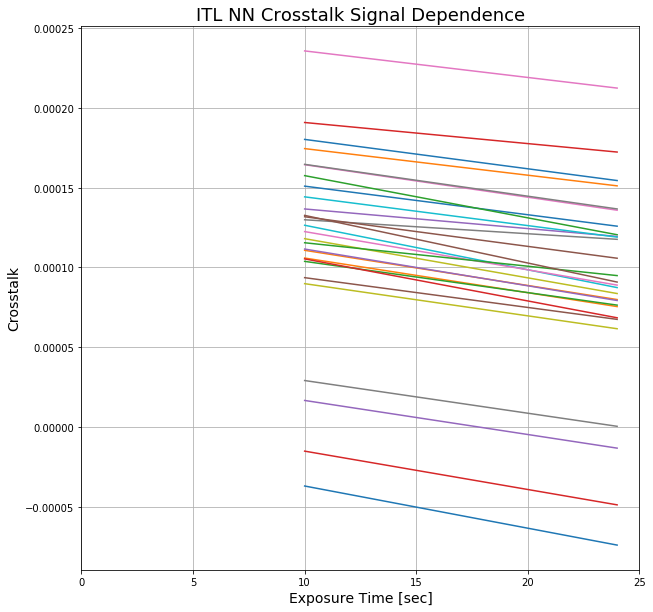

In [25]:
r = np.zeros((2, 28))
nn_up = np.diagonal(low_results[0].data, 1)
nn_up = np.delete(nn_up, (7,))
nn_down = np.diagonal(low_results[0].data, -1)
nn_down = np.delete(nn_down, (7,))
r[0, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(high_results[0].data, 1)
nn_up = np.delete(nn_up, (7,))
nn_down = np.diagonal(high_results[0].data, -1)
nn_down = np.delete(nn_down, (7,))
r[1, :] = np.append(nn_up, nn_down)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exptimes = np.asarray([10, 24])
for i in range(r.shape[1]):
    ax.plot(exptimes, r[:, i])
    
#ax.set_ylim(0, 0.0003)
ax.set_xlim(0, 25)
ax.grid(True, which='both')
ax.set_xlabel('Exposure Time [sec]', fontsize=14)
ax.set_ylabel('Crosstalk', fontsize=14)
ax.set_title('ITL NN Crosstalk Signal Dependence', fontsize=18)
plt.savefig('ITL_NN_xtalk_signal_dependence.png')

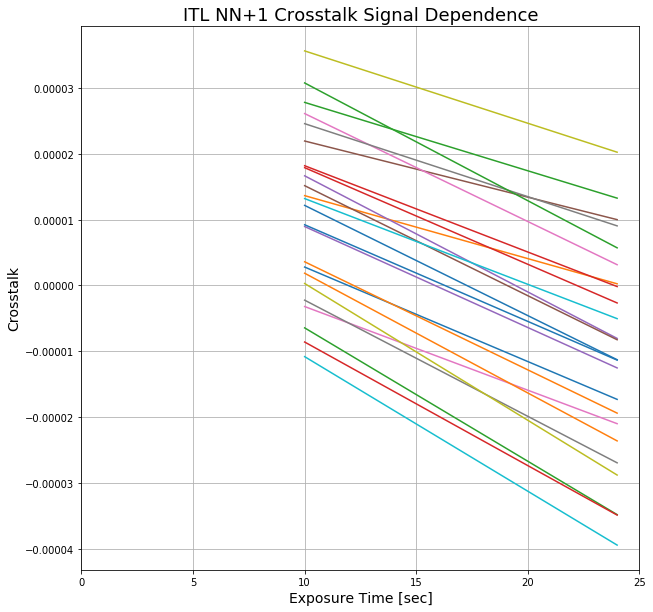

In [26]:
r = np.zeros((2, 24))
nn_up = np.diagonal(low_results[0].data, 2)
nn_up = np.delete(nn_up, (6, 7))
nn_down = np.diagonal(low_results[0].data, -2)
nn_down = np.delete(nn_down, (6, 7))
r[0, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(high_results[0].data, 2)
nn_up = np.delete(nn_up, (6, 7))
nn_down = np.diagonal(high_results[0].data, -2)
nn_down = np.delete(nn_down, (6, 7))
r[1, :] = np.append(nn_up, nn_down)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exptimes = np.asarray([10, 24])
for i in range(r.shape[1]):
    ax.plot(exptimes, r[:, i])
    
#ax.set_ylim(0, 0.0003)
ax.set_xlim(0, 25)
ax.grid(True, which='both')
ax.set_xlabel('Exposure Time [sec]', fontsize=14)
ax.set_ylabel('Crosstalk', fontsize=14)
ax.set_title('ITL NN+1 Crosstalk Signal Dependence', fontsize=18)
plt.savefig('ITL_NNp1_xtalk_signal_dependence.png')

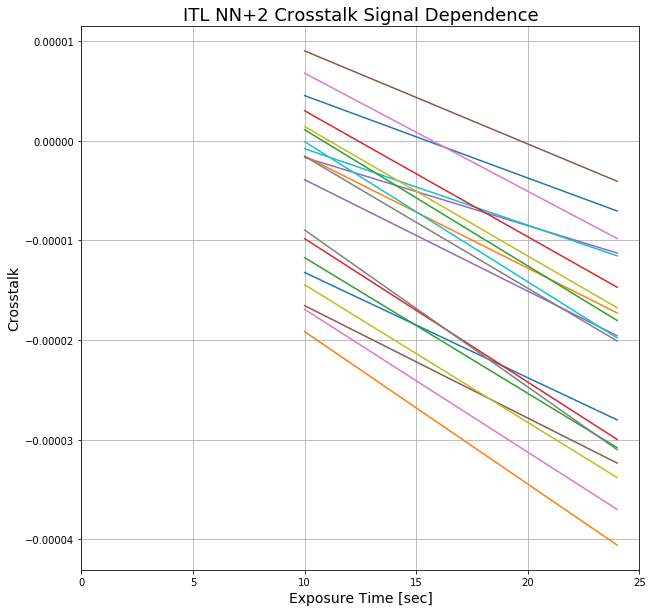

In [27]:
r = np.zeros((2, 20))
nn_up = np.diagonal(low_results[0].data, 3)
nn_up = np.delete(nn_up, (5, 6, 7))
nn_down = np.diagonal(low_results[0].data, -3)
nn_down = np.delete(nn_down, (5, 6, 7))
r[0, :] = np.append(nn_up, nn_down)

nn_up = np.diagonal(high_results[0].data, 3)
nn_up = np.delete(nn_up, (5, 6, 7))
nn_down = np.diagonal(high_results[0].data, -3)
nn_down = np.delete(nn_down, (5, 6, 7))
r[1, :] = np.append(nn_up, nn_down)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exptimes = np.asarray([10, 24])
for i in range(r.shape[1]):
    ax.plot(exptimes, r[:, i])
    
#ax.set_ylim(0, 0.0003)
ax.set_xlim(0, 25)
ax.grid(True, which='both')
ax.set_xlabel('Exposure Time [sec]', fontsize=14)
ax.set_ylabel('Crosstalk', fontsize=14)
ax.set_title('ITL NN+2 Crosstalk Signal Dependence', fontsize=18)
plt.savefig('ITL_NNp2_xtalk_signal_dependence.png')